# Optimal Transport for Two Marginals

TODO: theory

## Sinkhorn Algorithm

Find the desired measure
$$\Pi_{i,j} = a(x) K(x,y) b(y)$$
where
$$a(x) = \exp \left\{ \frac{u(x)}{\varepsilon} \right\}$$
$$b(y) = \exp \left\{ \frac{v(y)}{\varepsilon} \right\}$$
$$K(x, y) = \exp \left\{ - \frac{c(x, y)}{\varepsilon} \right\}$$

For the discrete case:
$$\Pi_{i,j} = a_{i} K_{i,j} b_{j}$$

where $a_{i}, K_{i,j}$ and $b_{j}$ are matrices.


TODO: input data

TODO: output data

TODO: complexity?

1. Initialize $a^{0} \equiv 1$
2. Update the 

In [143]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.transforms as transforms

In [167]:
def plot_discrete_ot_solution(P, p, q, figsize=(8, 6), print_matrix_elements_value=False):
    fig = plt.figure(figsize=figsize, layout=None, facecolor='lightgray')
    gs = fig.add_gridspec(nrows=2, ncols=2, left=0.15, right=0.85,
                        hspace=0.1, wspace=0.05,
                        width_ratios=[0.8, 0.2], height_ratios=[0.2, 0.8])
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.stem(np.arange(q.numpy().shape[0]), q.numpy())

    ax1 = fig.add_subplot(gs[1, 1])
    ax1.stem(np.arange(p.numpy().shape[0])[::-1] ,p.numpy(), orientation='horizontal')

    customColormap = ListedColormap(['#003f5c','#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600'])
    ax2 = fig.add_subplot(gs[1, 0])
    cax = ax2.matshow(P, cmap=customColormap)
    # Print the matrix element value in each cell as a text
    if print_matrix_elements_value:
        for i in range(P.shape[0]):
            for j in range(P.shape[1]):
                # print(P[i, j].numpy())
                ax2.text(j, i, str(round(P[i, j].numpy(), 4)), va='center', ha='center', color='white')
    # fig.colorbar(cax, ax=ax2)

    fig.suptitle('Discrete OT with regularization')

In [145]:
def sinkhorn(C, p, q, epsilon, max_iters=1000, stop_threshold=1e-9):
    """
    Sinkhorn algorithm for regularized optimal transport using TensorFlow.
    
    Args:
        C (tf.Tensor): Cost matrix of shape (N, M).
        p (tf.Tensor): Source distribution of shape (N, 1).
        q (tf.Tensor): Target distribution of shape (M, 1).
        epsilon (float): Regularization parameter.

        max_iters (int): Maximum number of iterations.
        stop_threshold (float): Convergence threshold.
    
    Returns:
        tf.Tensor: Regularized transport plan of shape (N, M).
    """
    
    # Compute the kernel matrix
    K = tf.exp(-C / epsilon)
    K_transpose = tf.transpose(K)
    
    # Initialize scaling vectors
    a = tf.ones_like(p)
    # b = tf.ones_like(q)
    
    # Sinkhorn iterations
    # prev_a = a
    for _ in range(max_iters):
        # b = 1. / (K_transpose @ a)
        # a = 1. / (K @ b)
        b = q / (K_transpose @ a)
        a = p / (K @ b)
        
        # Check for convergence
        # if tf.reduce_max(tf.abs(a - prev_a)) < stop_threshold:
        #     break
        # prev_a = a
    
    # Compute the transport plan
    a_expanded = tf.tile(a, [1, K.shape[1]])
    b_expanded = tf.tile(tf.transpose(b), [K.shape[1], 1])
    P = a_expanded * K * b_expanded
    
    return P

In [174]:
p = tf.constant([[0.3], [0.6], [0.1]])
q = tf.constant([[0.2], [0.2], [0.6]])
c = tf.constant([
    [1., 2., 2.],
    [2., 1., 1.],
    [3., 1., 2.],
])


P_prime = sinkhorn(c, p, q, 1/3)

In [147]:
# Check the solution
def check_transport_plan(P_prime, p, q, precision=1e-3, log=False):
    predicates = [
        (tf.reduce_sum(P_prime, axis=0) - tf.squeeze(q) < precision).numpy().all(),
        (tf.reduce_sum(P_prime, axis=1) - tf.squeeze(p) < precision).numpy().all(),
    ]
    if log:
        print('The sum of the transport plan matrix is:', tf.reduce_sum(P_prime).numpy())
        print('The solution preserves mass for q:', tf.reduce_sum(P_prime, axis=0) - tf.squeeze(q) < precision)
        print('The solution mass difference for q is:', (tf.reduce_sum(P_prime, axis=0) - tf.squeeze(q)).numpy())
        print('The solutions preserves mass for p:', tf.reduce_sum(P_prime, axis=1).numpy())
        print('The solution preserves mass for p:', tf.reduce_sum(P_prime, axis=1) - tf.squeeze(p) < precision)
        print('The solution mass difference for p is:', (tf.reduce_sum(P_prime, axis=1) - tf.squeeze(p)).numpy())
    return all(predicates)

In [175]:
check_transport_plan(P_prime, p, q, precision=1e-5, log=True)

The sum of the transport plan matrix is: 1.0
The solution preserves mass for q: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
The solution mass difference for q is: [ 0.0000000e+00 -1.4901161e-08  0.0000000e+00]
The solutions preserves mass for p: [0.29999998 0.6        0.1       ]
The solution preserves mass for p: tf.Tensor([ True  True  True], shape=(3,), dtype=bool)
The solution mass difference for p is: [-2.9802322e-08  0.0000000e+00  0.0000000e+00]


True

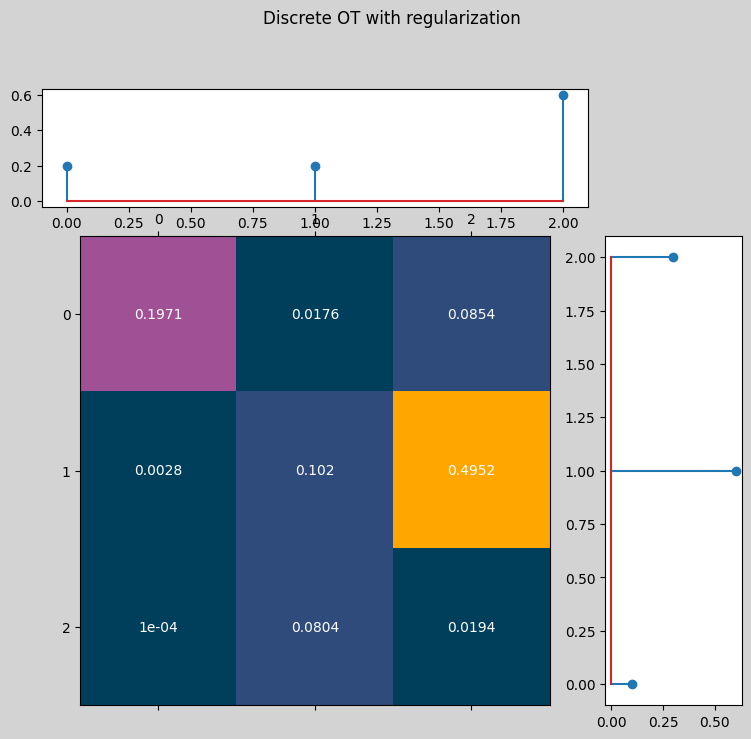

In [178]:
plot_discrete_ot_solution(P_prime, p, q, figsize=(10, 8), print_matrix_elements_value=True)

In [168]:
def generate_1d_problem(n, m, p_mean, q_mean, p_stddev, q_stddev, c_lambda=2):
    p = tf.random.normal([n, 1], p_mean, p_stddev)
    p += tf.reduce_min(p) * 2
    p /=  tf.reduce_sum(p)
    q = tf.random.normal([m, 1], q_mean, q_stddev)
    q += tf.reduce_min(q)
    q /=  tf.reduce_sum(q) * 2
    c = tf.random.poisson([n, m], c_lambda)

    return p, q, c

tf.Tensor(
[[ 0.02502238]
 [-0.01845964]
 [ 0.02590082]
 [ 0.04428966]
 [ 0.05407646]
 [ 0.04609812]
 [ 0.00431589]
 [ 0.04641731]
 [ 0.06025983]
 [ 0.0183786 ]
 [ 0.03751928]
 [ 0.03980859]
 [ 0.0701195 ]
 [ 0.05318369]
 [ 0.02096011]
 [ 0.02161773]
 [ 0.01118029]
 [ 0.0385602 ]
 [ 0.03657968]
 [ 0.02847918]
 [ 0.03167628]
 [ 0.02393025]
 [ 0.02347145]
 [ 0.04148362]
 [-0.00294332]
 [ 0.01931266]
 [ 0.02007426]
 [ 0.06437244]
 [ 0.05725576]
 [ 0.05705886]], shape=(30, 1), dtype=float32)
tf.Tensor(
[[0.01585038]
 [0.01972827]
 [0.02207555]
 [0.01049815]
 [0.01027357]
 [0.02706983]
 [0.01982147]
 [0.00723459]
 [0.02140664]
 [0.01760282]
 [0.02569943]
 [0.0289516 ]
 [0.01174365]
 [0.01207715]
 [0.01779447]
 [0.00878189]
 [0.02352093]
 [0.01826063]
 [0.01529697]
 [0.02299653]
 [0.01563896]
 [0.00482678]
 [0.02744515]
 [0.02476162]
 [0.01380801]
 [0.00986604]
 [0.01869467]
 [0.0099522 ]
 [0.00411967]
 [0.01420238]], shape=(30, 1), dtype=float32)
tf.Tensor(
[[nan nan nan nan nan nan nan nan

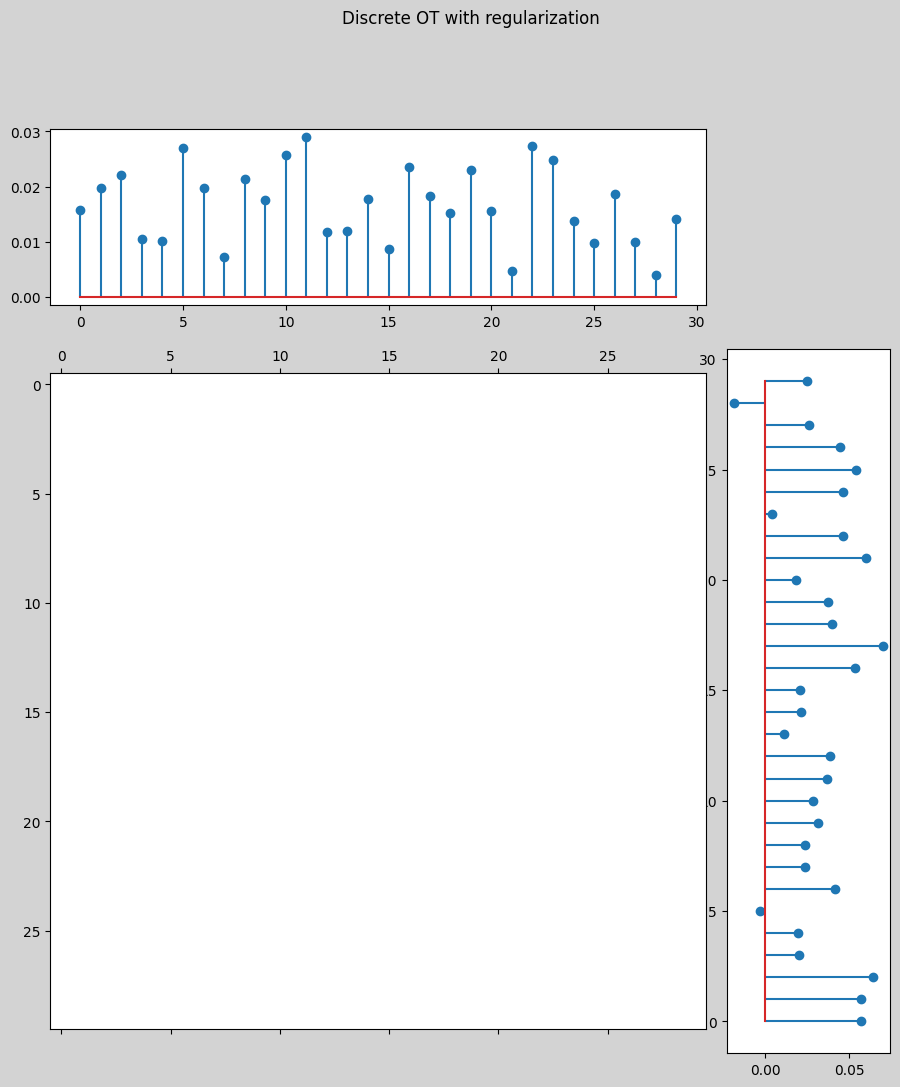

In [172]:
p, q, c = generate_1d_problem(10, 10, 1, 3, 0.5, 2)

print(p)
print(q)

eps = .05
P_prime = sinkhorn(c, p, q, epsilon=eps)

print(P_prime)

print('Is the solution ok? -- ', check_transport_plan(P_prime, p, q, log=True))

plot_discrete_ot_solution(P_prime, p, q, figsize=(12, 12))